<a href="https://colab.research.google.com/github/Hasim-dev/MNIST-Digit-Recognition/blob/master/MNIST_CNN_(PyTorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [0]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([transforms.Resize((28, 28)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)) # mean ve std
                               ]) # transform'u oluşturduk. ToTensor ve Normalize ile tensora dönüştürdük ve normalize ettik

# /data içine data'yı koy, train_set oluştur, indir, transform'u koy
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# epoch için tek seferde 60.000 image fazla olur. "batch_size" ile bölüyoruz. "shuffle" global minimum içindi.
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=False)

0it [00:00, ?it/s]

 99%|█████████▉| 9854976/9912422 [00:27<00:00, 550287.02it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



0it [00:00, ?it/s]
  0%|          | 0/28881 [00:00<?, ?it/s]


32768it [00:00, 135341.97it/s]           
0it [00:00, ?it/s]
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



 95%|█████████▍| 1564672/1648877 [00:03<00:00, 582637.45it/s]

0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




  0%|          | 0/4542 [00:00<?, ?it/s]

8192it [00:00, 49269.11it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
# Tensor image'leri plot etmek için tekrar numpy arraye dönüştürmemiz gerekiyor.
def im_convert(tensor):
  
  # Tensor; color channel, width, channel sütunlarından oluşur. (1, 28, 28)
  image = tensor.clone().detach().numpy() 
  
  # (1, 28, 28) oldu
  image = image.transpose(1, 2, 0) 
  #print(image.shape)
  
  # Denormalization
  image = image * np.array([0.5, 0.5, 0.5] + np.array([0.5, 0.5, 0.5]))
  
  #Mormalizing the image mader our image -1 to 1. To ensure that the image is 0 to 1.
  image = image.clip(0, 1)
  
  return image

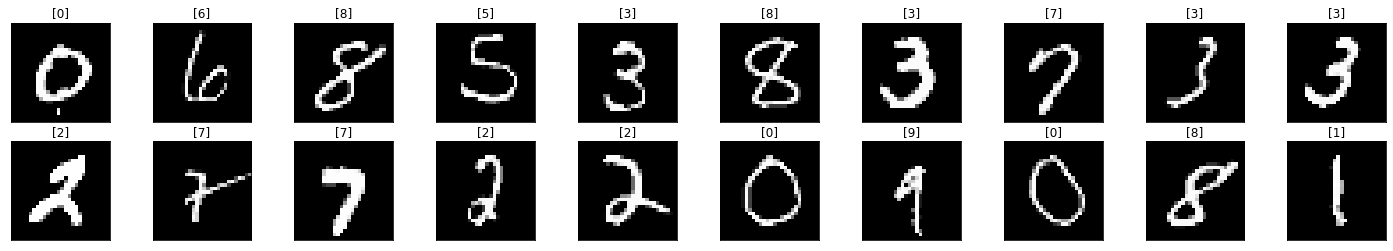

In [5]:
dataiter = iter(training_loader) # training loader(bir iterable) üzerinden iterate edecek.
images, labels = dataiter.next() # access it one at a time with next(), returns image, label
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) # rows, columns, index
  plt.imshow(im_convert(images[idx])) # images[idx] tensor döndürür, np array için "im_convert"e sokuyoruz.
  ax.set_title([labels[idx].item()]) #her image için title

In [0]:
class LeNet(nn.Module):
  # hidden layer sayısı, argument sayısını belirler. input, D1, D2, output layerindaki node sayısı argument olarak verilir.
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 20, 5, 1) #(input kanal sayısı, feature extr. için kernel sayısı, kernel boyutu, stride uzunluğu),  input conv layer defined
    #28x28 boyut, conv'dan sonra 24x24 oldu. poolingden sonra 12x12 oldu (2x2 kernel ile yarıya düşürdü).
    
    self.conv2 = nn.Conv2d(20, 50, 5, 1) #(input kanalı öncekinin outputu kadar yani 20, output 50 seçtik)
    #12x12 boyut, conv'dan sonra 8x8 oldu. poolingden sonra 4x4 oldu (2x2 kernel ile yarıya düşürdü).
    
    #fc1 layerına 4x4x50=800 kadar input olur. 50 katmanlı conv2 layerı ve 4x4 feature image ile gelmişti.
    self.fc1 = nn.Linear(4*4*50, 500) #nn.Linear(input sayısı, output sayısı)
    # dropout layerları genelde parameter sayıları yüksek olan layerlar arasında kullanılır
    self.dropout1 = nn.Dropout(0.5)
    # (öncekinin 500 outputu bu layerin inputu oldu, 10 output 0-9 arası rakamlar)
    self.fc2 = nn.Linear(500, 10) 
    
  def forward(self, x):
    x = F.relu(self.conv1(x)) # conv1 çıkışına uygulandı. activation func. (negatif değerler "0" olur)
    x = F.max_pool2d(x, 2, 2) #pooling layer: image size yarıya düştü
    
    x = F.relu(self.conv2(x)) # conv2 çıkışına uygulandı. activation func. (negatif değerler "0" olur)
    x = F.max_pool2d(x, 2, 2) #pooling layer: image size yarıya düştü
    
    x = x.view(-1, 4*4*50) # (nr. cols, nr. rows) x'i istediğimiz shape'e sokuyoruz. FC layera girmeden flattened(düzlenmiş) olması gerekiyordu.
    
    x = F.relu(self.fc1(x)) # fc1 çıkışına relu uyguluyoruz.
    x = self.dropout1(x)
    x = self.fc2(x) # relu çıkışını da fc2ye veriyoruz.
    
    # Burada en son çıkışa activ. func. uygulamıyoruz.
    # Daha sonra nn.CrossEntropyLoss()'yi kullanacağız.'
    return x

In [44]:
model = LeNet()#.to(device)
model # modeli görelim.

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [46]:
epochs = 15
running_loss_history = []
running_corrects_history = []

val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  for inputs, labels in training_loader:
    #inputs = inputs.to(device)
    #labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels) # output ve labellar karşılaştırılıyor.
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # gelen outputlardan max değerli olanı alıyoruz.
    # ilk değer max score, ikinci değer max score'un index değerini döndürüyor.
    _, preds = torch.max(outputs, 1) 
    running_loss += loss.item()
    # single batch of images'da doğru prediction sayısını veriyor.
    running_corrects += torch.sum(preds == labels.data) 
        
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        #val_inputs = val_inputs.to(device)
        #val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1) 
        val_running_loss += val_loss.item()
        # single batch of images'da doğru prediction sayısını veriyor.
        val_running_corrects += torch.sum(val_preds == val_labels.data) 
    
    
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/len(training_loader)
    running_loss_history.append(epoch_loss) #epoch_loss, listeye eklendi.
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch', (e+1))
    print('Training Loss: {:.4f}, acc {:.4f}' .format(epoch_loss, epoch_acc.item()))
    print('Validation Loss: {:.4f}, acc {:.4f}' .format(val_epoch_loss, val_epoch_acc.item()))
    

epoch 1
Training Loss: 0.5875, acc 83.7950
Validation Loss: 0.1796, acc 94.9700
epoch 2
Training Loss: 0.1496, acc 95.4550
Validation Loss: 0.1053, acc 96.9300
epoch 3
Training Loss: 0.1012, acc 96.9467
Validation Loss: 0.0785, acc 97.6700
epoch 4
Training Loss: 0.0787, acc 97.6250
Validation Loss: 0.0625, acc 98.0000
epoch 5
Training Loss: 0.0646, acc 98.0317
Validation Loss: 0.0521, acc 98.2600
epoch 6
Training Loss: 0.0554, acc 98.3417
Validation Loss: 0.0491, acc 98.3400
epoch 7
Training Loss: 0.0499, acc 98.4667
Validation Loss: 0.0411, acc 98.6500
epoch 8
Training Loss: 0.0440, acc 98.6567
Validation Loss: 0.0393, acc 98.6000
epoch 9
Training Loss: 0.0398, acc 98.8033
Validation Loss: 0.0385, acc 98.6900
epoch 10
Training Loss: 0.0366, acc 98.9033
Validation Loss: 0.0360, acc 98.8900
epoch 11
Training Loss: 0.0335, acc 98.9383
Validation Loss: 0.0365, acc 98.8000
epoch 12
Training Loss: 0.0316, acc 99.0500
Validation Loss: 0.0340, acc 98.7600
epoch 13
Training Loss: 0.0285, acc 9

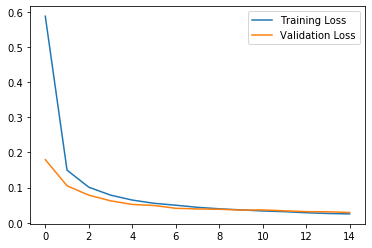

In [48]:
plt.plot(running_loss_history, label='Training Loss')
plt.plot(val_running_loss_history, label='Validation Loss')
plt.legend()

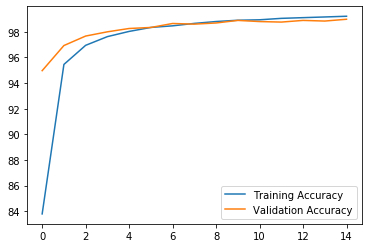

In [49]:
plt.plot(running_corrects_history, label='Training Accuracy')
plt.plot(val_running_corrects_history, label='Validation Accuracy')
plt.legend()

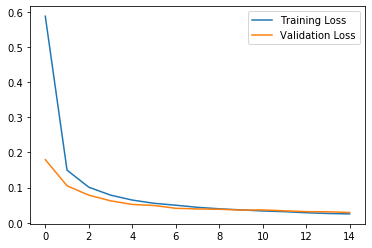

In [50]:
plt.plot(running_loss_history, label='Training Loss')
plt.plot(val_running_loss_history, label='Validation Loss')
plt.legend()
plt.show()

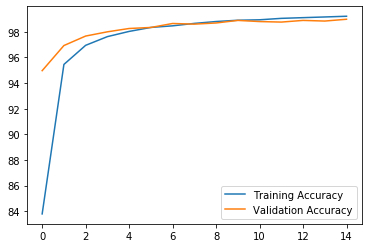

In [51]:
plt.plot(running_corrects_history, label='Training Accuracy')
plt.plot(val_running_corrects_history, label='Validation Accuracy')
plt.legend()
plt.show()

<Response [200]>


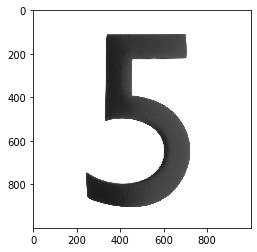

In [52]:
import requests
import PIL.ImageOps
from PIL import Image
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)
print(response)

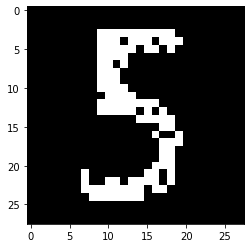

In [53]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img))

In [54]:
#images = img.to(device)
image = img[0].unsqueeze(0).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1) 
print(pred.item())

5


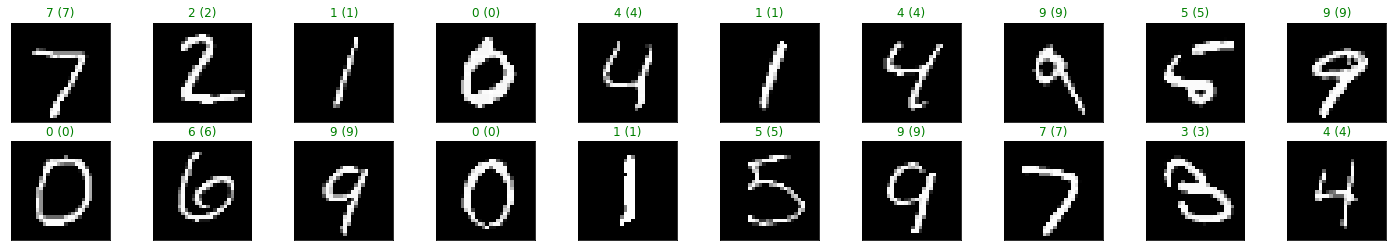

In [56]:
dataiter = iter(validation_loader) # training loader(bir iterable) üzerinden iterate edecek.
images, labels = dataiter.next() # access it one at a time with next(), returns image, label
images = images#.to(device)
labels = labels#.to(device)
output = model(images)
_, preds = torch.max(output, 1) 

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) # rows, columns, index
  plt.imshow(im_convert(images[idx])) # images[idx] tensor döndürür, np array için "im_convert"e sokuyoruz.
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color = ("green" if preds[idx]==labels[idx] else "red")) #her image için title